In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Load business file
df_b = pd.read_parquet("../datasets/parquet_file/business_filtered.parquet")

In [6]:
# Load check_in file
df_c = pd.read_parquet("../datasets/parquet_file/check_in.parquet")

In [7]:
# Load review file
df_r = pd.read_parquet("../datasets/parquet_file/review_filtered.parquet")

In [8]:
# Load user file
df_u = pd.read_parquet("../datasets/parquet_file/user.parquet")

# Create variables for loyalty_score

In [9]:
# -------------------------
# 1. regular_customer_score
# -------------------------

# Calculate unique user ratio
total_reviews = df_r.groupby('business_id')['review_id'].count()
unique_users = df_r.groupby('business_id')['user_id'].nunique()

user_loyalty_df = pd.DataFrame({
    'total_reviews': total_reviews,
    'unique_users': unique_users
})

user_loyalty_df['unique_user_ratio'] = user_loyalty_df['unique_users'] / user_loyalty_df['total_reviews']
user_loyalty_df['repeat_user_ratio'] = 1 - user_loyalty_df['unique_user_ratio']

df_b = df_b.merge(user_loyalty_df[['repeat_user_ratio']], on='business_id', how='left')

In [10]:
# Calculate average star rating left by repeat users per business
user_review_counts = df_r.groupby(['business_id', 'user_id'])['review_id'].count().reset_index(name='review_count')
repeat_users = user_review_counts[user_review_counts['review_count'] >= 2][['business_id', 'user_id']]

repeat_reviews = df_r.merge(repeat_users, on=['business_id', 'user_id'], how='inner')

repeat_user_avg_stars = repeat_reviews.groupby('business_id')['stars'].mean().reset_index(name='repeat_user_avg_stars')

df_b = df_b.merge(repeat_user_avg_stars, on='business_id', how='left')

In [11]:
# Fill missing values with 0 or default value
df_b['repeat_user_ratio'] = df_b['repeat_user_ratio'].fillna(0)
df_b['repeat_user_avg_stars'] = df_b['repeat_user_avg_stars'].fillna(3)  

# Base score
base_score = 25

# Score 1: Convert repeat user ratio to a 0–15 point scale
score_ratio = df_b['repeat_user_ratio'] * 15  

# Score 2: Adjust ±10 points based on how much repeat user rating deviates from 3.0
score_stars = (df_b['repeat_user_avg_stars'] - 3) * (10 / 2)  

# Final score calculation
df_b['regular_customer_score'] = (base_score + score_ratio + score_stars)

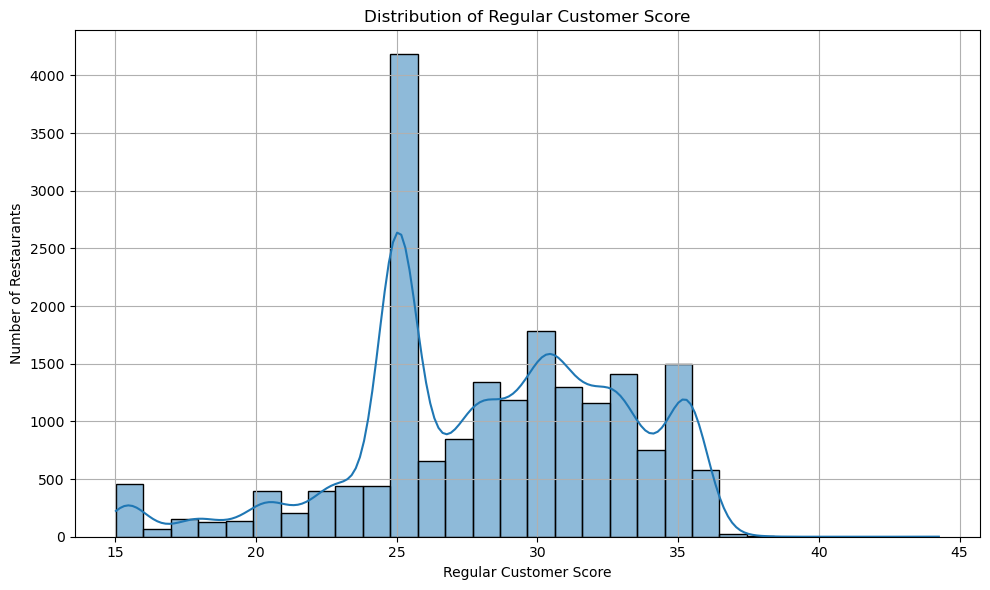

In [12]:
# Check the distribution of Regular Customer Score

plt.figure(figsize=(10, 6))
sns.histplot(df_b['regular_customer_score'], bins=30, kde=True)

plt.title('Distribution of Regular Customer Score')
plt.xlabel('Regular Customer Score')
plt.ylabel('Number of Restaurants')
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
df_b.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,repeat_user_ratio,repeat_user_avg_stars,regular_customer_score
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Friday': '7:0-21:0', 'Monday': '7:0-20:0', '...",0.080460,4.076923,31.591512
1,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","American (Traditional), Restaurants, Diners, B...","{'Friday': '6:0-22:0', 'Monday': '6:0-22:0', '...",0.034483,4.000000,30.517241
2,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Food, Delis, Italian, Bakeries, Restaurants","{'Friday': '10:0-20:0', 'Monday': '10:0-18:0',...",0.056604,4.500000,33.349057


In [14]:
# -------------------------
# 2. Calculate checkin_count_score
# -------------------------

# Count total check-ins per business
df_c['checkin_list'] = df_c['date'].apply(
    lambda x: str(x).split(',') if pd.notnull(x) else []
)

df_c['checkin_count'] = df_c['checkin_list'].apply(len)

In [15]:
# Merge df_c (check-in info) into df_b
df_b = df_b.merge(
    df_c[['business_id', 'checkin_count']],
    on='business_id',
    how='left'
)

# Fill missing values (for businesses without check-in records)
df_b['checkin_count'] = df_b['checkin_count'].fillna(0).astype(int)

In [16]:
# Log transform
df_b['checkin_count_log'] = np.log1p(df_b['checkin_count'])

# Min-Max Scaling and convert to 0–20 point scale
scaler = MinMaxScaler(feature_range=(0, 20))
df_b['checkin_count_score'] = scaler.fit_transform(df_b[['checkin_count_log']])

# Round to 2 decimal places
df_b['checkin_count_score'] = df_b['checkin_count_score'].round(2)


In [17]:
# -------------------------
# 3. Calculate checkin_interval
# -------------------------

# Function to calculate the average check-in interval (in days)
def calc_checkin_interval(date_str):
    """Calculate the average interval between check-ins (in days) from a comma-separated string"""
    if pd.isna(date_str):  # Handle missing values
        return np.nan
    
    # Split the string by commas and convert each part into a datetime object
    dates = [pd.to_datetime(d.strip(), format='%Y-%m-%d %H:%M:%S', errors='coerce')
             for d in date_str.split(',')]
    
    # Remove invalid (NaT) values
    dates = [d for d in dates if pd.notnull(d)]
    if len(dates) <= 1:  # Need at least two dates to calculate interval
        return np.nan
    
    # Sort the dates and compute time differences
    dates = sorted(dates)
    diffs = np.diff(dates)  # returns an array of timedelta64[ns]
    
    # ✅ Fix: use total_seconds() to convert Timedelta to days
    avg_days = np.mean([diff.total_seconds() / (60 * 60 * 24) for diff in diffs])
    return avg_days

# Apply the function to the 'date' column
df_c['checkin_interval'] = df_c['date'].apply(calc_checkin_interval)

# Check the results
df_c[['business_id', 'checkin_count', 'checkin_interval']].head()

,business_id,checkin_count,checkin_interval
0,---kPU91CF4Lq2-WlRu9Lw,11,60.780063
1,--0iUa4sNDFiZFrAdIWhZQ,10,145.228521
5,--8IbOsAAxjKRoYsBFL-PA,32,36.543712
18,--ZVrH2X2QXBFdCilbirsw,67,38.316925
24,--epgcb7xHGuJ-4PUeSLAw,118,32.794271


In [18]:
# Merge df_c (check-in info) into df_b
df_b = df_b.merge(
    df_c[['business_id', 'checkin_interval']],
    on='business_id',
    how='left'
)

# Fill missing values (for businesses without check-in records)
df_b['checkin_interval'] = df_b['checkin_interval'].fillna(0).astype(int)

In [19]:
# Check result
df_b.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,attributes,categories,hours,repeat_user_ratio,repeat_user_avg_stars,regular_customer_score,checkin_count,checkin_count_log,checkin_count_score,checkin_interval
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Friday': '7:0-21:0', 'Monday': '7:0-20:0', '...",0.080460,4.076923,31.591512,335,5.817111,11.33,12
1,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,...,"{'AcceptsInsurance': None, 'AgesAllowed': None...","American (Traditional), Restaurants, Diners, B...","{'Friday': '6:0-22:0', 'Monday': '6:0-22:0', '...",0.034483,4.000000,30.517241,54,4.007333,7.80,75
2,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,...,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Food, Delis, Italian, Bakeries, Restaurants","{'Friday': '10:0-20:0', 'Monday': '10:0-18:0',...",0.056604,4.500000,33.349057,264,5.579730,10.86,11
3,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,...,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Sushi Bars, Restaurants, Japanese","{'Friday': '13:30-23:0', 'Monday': None, 'Satu...",0.020000,4.200000,31.300000,172,5.153292,10.03,8
4,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,...,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Korean, Restaurants","{'Friday': '11:30-20:30', 'Monday': '11:30-20:...",0.014423,4.333333,31.883013,221,5.402677,10.52,13


In [20]:
# Log transform 
df_b['checkin_interval_log'] = np.log1p(df_b['checkin_interval'])

# Min-Max normalization and convert to 0–30 point scale
scaler = MinMaxScaler(feature_range=(0, 30))
df_b['checkin_interval_score'] = scaler.fit_transform(df_b[['checkin_interval_log']])

# Invert the score so that lower intervals yield higher scores, then scale to 30 points
df_b['checkin_interval_score'] = (30 - df_b['checkin_interval_score'])

# Round to 2 decimal places
df_b['checkin_interval_score'] = df_b['checkin_interval_score'].round(2)

In [21]:
df_b[['regular_customer_score', 'checkin_count_score', 'checkin_interval_score']]

,regular_customer_score,checkin_count_score,checkin_interval_score
0,31.591512,11.33,20.01
1,30.517241,7.80,13.13
2,33.349057,10.86,20.32
3,31.300000,10.03,21.44
4,31.883013,10.52,19.72
...,...,...,...
19529,25.000000,12.02,23.73
19530,32.196970,10.96,19.45
19531,25.000000,10.52,18.33
19532,15.576923,9.25,16.88


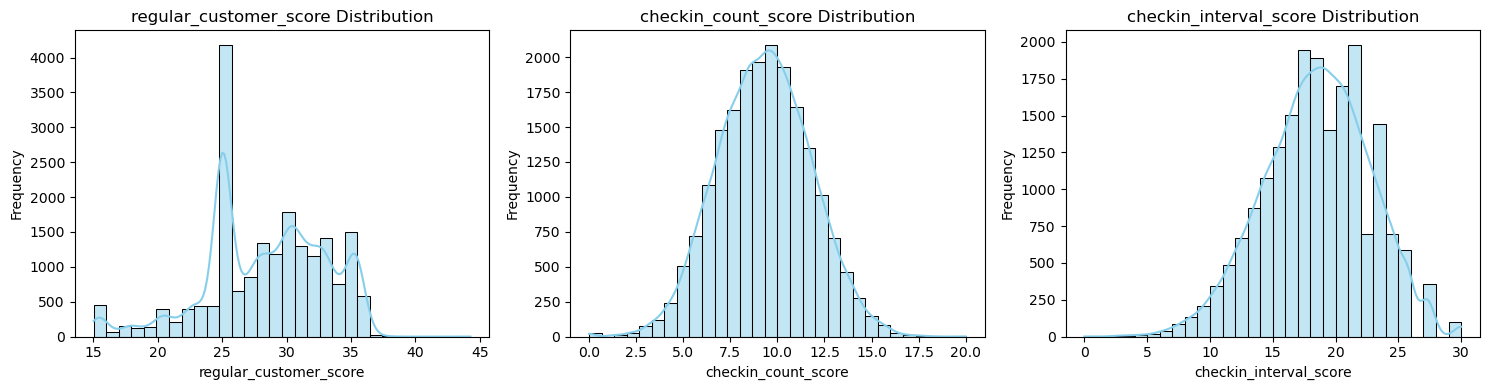

In [22]:
# Select the columns of interest
cols = ['regular_customer_score', 'checkin_count_score', 'checkin_interval_score']

# Basic distribution
plt.figure(figsize=(15, 4))
for i, col in enumerate(cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df_b[col], bins=30, kde=True, color='skyblue')
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Calculate loyalty score

In [23]:
# Calculate final loyalty score

df_b['loyalty_score'] = df_b['regular_customer_score'] + df_b['checkin_interval_score'] + df_b['checkin_count_score']

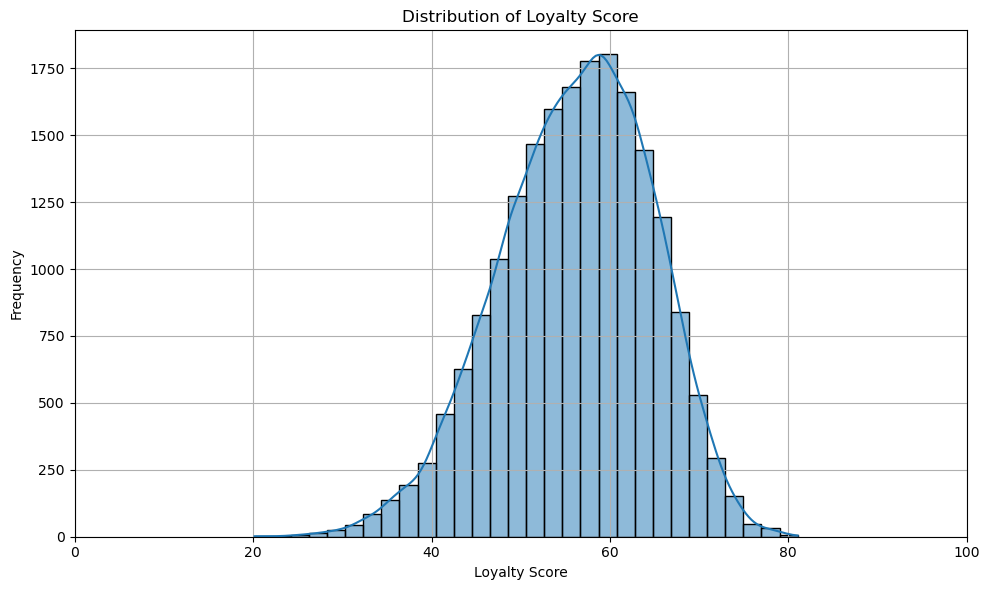

In [24]:
# Check distribution

plt.figure(figsize=(10, 6))
sns.histplot(df_b['loyalty_score'], bins=30, kde=True)

plt.title('Distribution of Loyalty Score')
plt.xlabel('Loyalty Score')
plt.ylabel('Frequency')
plt.xlim(0,100)
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
df_b.to_csv('../datasets/business1.csv', index=False)